# Espaços de ação contínuos (DDPG)

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="platoon.png" width="300">

Objetivo: usar o algoritmo do *Deep Deterministic Policy Gradient* (DDPG) para encontrar uma política $\pi(s,\boldsymbol{\theta})$ que controle um comboio de (dois) veículos.

## Características do ambiente:

O ambiente é composto por dois veículos que viajam longitudinalmente em uma estrada, um líder e um seguidor. O objetivo principal é calcular os comandos de aceleração $u_1(t)$ do veículo seguidor em função do erro de sua posição $e_p(t)$, velocidade $e_v(t)$ e aceleração $e_a(t)$ em relação ao líder.

### Espaço de observações

Erros de posição, velocidade e aceleração do seguidor em relação ao líder:

$
\begin{bmatrix}
    e_p(t)\\
    e_v(t)\\
    e_a(t)
\end{bmatrix}
=
\begin{bmatrix}
    p_1(t) - p_0(t) - \delta_{0,1}\\
    v_1(t) - v_0(t)\\
    a_1(t) - a_0(t)
\end{bmatrix}$


### Espaço de ações

Comando de aceleração $u_1(t)$ para o veículo seguidor, limitado a $-3m/s^2 \leq u_1(t) \leq 3m/s^2$.

### Função de recompensa

O objetivo da função de recompensa é reduzir os erros de posição, velocidade e aceleração, aplicando um comando de aceleração que esforço o acelerador o mínimo possível. Formalmente,

$r(t) = \dfrac{1}{e^k}$, onde $k = 0.3 e_p(t)^2 + 0.3 e_v(t)^2 + 0.3 e_a(t)^2 + 0.2 u_1(t)^2.$


Importando as bibliotecas.

In [1]:
try:
    import gymnasium as gym
except:
    import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from collections import deque, namedtuple
import random
import class_env as ce
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,4)

Gerenciando o replay buffer. O buffer tem tamanho fixo e armazena tuplas de experiências com o ambiente.

In [2]:
class ReplayBuffer:
    ##########################################
    def __init__(self, parameters, buffer_size=int(1e5)):
        
        self.batch_size = parameters['batch_size']
        self.device = parameters['device']
        
        self.D = deque(maxlen=buffer_size)  
        self.experience = namedtuple("Experience", field_names=["S", "A", "R", "Sl", "done"])
    
    ##########################################
    # Adiciona uma nova experiencia ao buffer
    def push(self, S, A, R, Sl, done):
        e = self.experience(S, A, R, Sl, done)
        self.D.append(e)
    
    ##########################################
    # Escolhe aleatoriamente um mini-lote das experiencias
    def sample(self):
        Dj = random.sample(self.D, k=np.min([len(self.D), self.batch_size]))
        states = torch.from_numpy(np.vstack([e.S for e in Dj if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.A for e in Dj if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.R for e in Dj if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.Sl for e in Dj if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in Dj if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
    
    ##########################################
    def __len__(self):
        return len(self.D)

Ruído de exploração da ação contínua, implementando como um processo de Ornstein–Uhlenbeck https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process.

In [3]:
class OUNoise(object):
    ###########################################
    def __init__(self, action_space, mu=0.0, theta=0.5, sigma=0.15, dt=1e-2):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = sigma
        self.dt           = dt
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    ###########################################
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    ###########################################
    def evolve_state(self):
        x  = self.state
        dx = self.theta*(self.mu - x)*self.dt + self.sigma*np.random.randn(self.action_dim)*np.sqrt(self.dt)
        self.state = x + dx
        return self.state

    ###########################################
    def get(self):
        return self.evolve_state()

O *ator* é representado pela função diferenciável $\pi(s, \boldsymbol{\theta})$ que fornece uma ação $a$ dado um estado $s$. A arquitetura da Rede Neural Artificial (Perceptron) tem ```state_size``` entradas, ```action_size``` saídas e uma camada escondida de tamanho ```hidden_size```.

In [4]:
class Actor(nn.Module):
    ###########################################
    def __init__(self, input_size, output_size, hidden_size=32, temperature=1.0):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        
        self.temperature = temperature # suaviza a entrada da tanh

    ###########################################
    def forward(self, state):
        x = F.leaky_relu(self.linear1(state), negative_slope=0.01)
        return torch.tanh(self.linear2(x)/self.temperature)

O *crítico* é representado pela função diferenciável $\hat{q}(s, a, \boldsymbol{w})$ que fornece o valor de um dado $s$ e uma dada ação $a$. A arquitetura da Rede Neural Artificial (Perceptron) tem ```state_size``` entradas, uma saída e uma camada escondida de tamanho ```hidden_size```.

In [5]:
class Critic(nn.Module):
    ###########################################
    def __init__(self, input_size, output_size, hidden_size=32):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    ###########################################
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

Criando a classe do algortimo do DDPG.

In [6]:
class DDPG:
    ###########################################
    def __init__(self, parameters):
        
        self.parameters = parameters

        # numero de episodios
        self.episode = 0
        self.max_iter = parameters['max_iter']
        
        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.alpha = parameters['alpha']
        self.beta = parameters['beta']
        self.tau = parameters['tau']
        self.batch_size = parameters['batch_size']
        self.device = parameters['device']

        # cria ambiente
        self.env = ce.PlatoonEnv()
        
        # cria ruído de exploração da ação contínua
        self.noise = OUNoise(self.env.action_space, dt=ce.DT)
        
        # Params
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.shape[0]

        # Redes principais
        self.actor  = Actor(self.num_states, self.num_actions).to(self.device)
        self.critic = Critic(self.num_states + self.num_actions, self.num_actions).to(self.device)
        
        # Redes-alvo
        self.actor_target  = Actor(self.num_states, self.num_actions).to(self.device)
        self.critic_target = Critic(self.num_states + self.num_actions, self.num_actions).to(self.device)
        #
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        #
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Buffer de armazenamento de experiencias
        self.D = ReplayBuffer(parameters)
        
        # Treinando
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=self.beta)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha)

    ###########################################
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        action = self.actor.forward(state)
        return action.cpu().detach().numpy()

Atualize $\boldsymbol{w}$ (crítico) minimizando a perda:

$y_j =  R_j + \gamma \hat{q}(S'_j, \mu(S'_j,\widetilde{\boldsymbol{\theta}}), \widetilde{\boldsymbol{w}})$ ($R_j$ se $S'_j$ for terminal)

$L = \frac{1}{N} \sum_{j} (y_j - \hat{q}(S'_j, A_j, \boldsymbol{w}))^2$

Atualize $\boldsymbol{\theta}$ (ator) usando o gradiente de política amostrado:

$\nabla_{\boldsymbol{\theta}} \approx \frac{1}{N} \sum_{j} \nabla_a \hat{q}(s,a,\boldsymbol{w})|_{s=S_j, a=\pi(S_j,\boldsymbol{\theta})} \nabla_{\boldsymbol{\theta}} \pi(s,\boldsymbol{\theta})|_{s=S_j}$      

In [7]:
class DDPG(DDPG):
    ###########################################
    def update(self):
        
        # Seleciona um mini-lote Dj de D e aprende
        Ss, As, Rs, Sls, ds = self.D.sample()
        
        # alvo
        Als = self.actor_target.forward(Sls)
        y = Rs + (1.0 - ds)*self.gamma*self.critic_target.forward(Sls, Als.detach())
        
        # Perda do crítico
        critic_loss = F.mse_loss(self.critic.forward(Ss, As), y)

        # Perda do ator
        policy_loss = -self.critic.forward(Ss, self.actor.forward(Ss)).mean()

        # update do ator
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # update do crítico
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

Faz a atualização das redes-alvo:

$\widetilde{\boldsymbol{w}} \gets \tau \boldsymbol{w} + (1-\tau) \widetilde{\boldsymbol{w}}$

$\widetilde{\boldsymbol{\theta}} \gets \tau \boldsymbol{\theta} + (1-\tau) \widetilde{\boldsymbol{\theta}}$

In [8]:
class DDPG(DDPG):
    ###########################################
    def softUpdade(self):
        # update ator
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
        # update crítico
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

Executando um episódio.

In [9]:
class DDPG(DDPG):
    ##########################################
    def runEpisode(self):
        
        # novo episodio
        self.episode += 1
        
        rewards = []
        
        # reseta noise
        self.noise.reset()

        # reseta o ambiente
        S, _ = self.env.reset()
        
        # Gerando a experiencia a partir da politica
        for _ in range(self.max_iter):
            
            # ação + ruido
            A = self.get_action(S) + self.noise.get()
            A = np.clip(A, -1.0, 1.0)
            
            # aplica ação
            Sl, R, done, _, _ = self.env.step(A)
            rewards.append(R)
            
            # Armazena a experiencia (S,A,R,Sl) no buffer D
            self.D.push(S, A, R, Sl, done)
            
            # atualiza as redes principais
            self.update()
            
            # atualiza as redes-alvo
            self.softUpdade()

            if done: 
                break
            
            S = Sl
                    
        return np.sum(np.array(rewards))

Programa principal:
- episodes: número de episódios
- max_iter: máximo de iterações até o fim do episódio
- gamma: fator de desconto
- alpha: $\alpha$
- beta: $\beta$
- tau: $\tau$ (atualização das redes alvo)
- device: usa *cpu* ou *gpu*

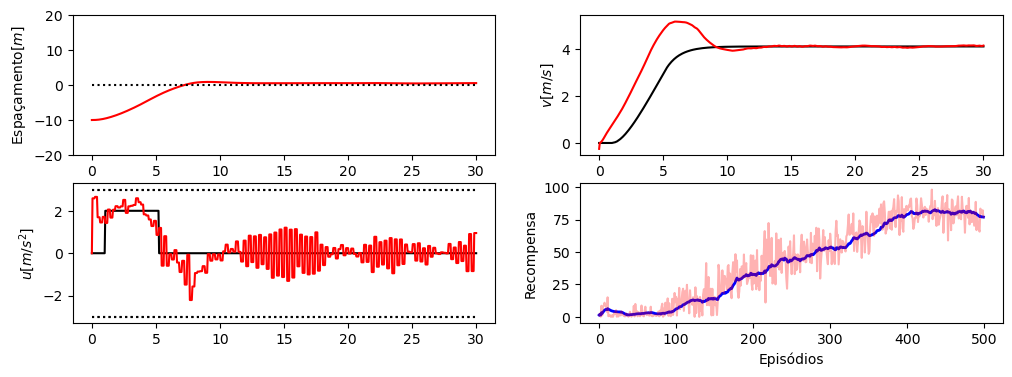

In [10]:
if __name__ == '__main__':

    plt.ion()

    # parametros
    parameters = {'episodes'  : 500,
                  'max_iter'  : 1000,
                  'n_agents'  : 10,
                  'gamma'     : 0.99,
                  'alpha'     : 2.0e-3,
                  'beta'      : 1.0e-3,
                  'tau'       : 1.0e-3,
                  'device'    : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                  'batch_size': 64,
                 }

    # historico dos reforços
    rewards = []
    avg_rewards = []

    # cria 'n_agents' para observar comportamento médio
    ddpg = [DDPG(parameters) for _ in range(parameters['n_agents'])]

    while ddpg[0].episode <= parameters['episodes']:

        # roda um episodio para cada agente
        total_reward = [ddpg[i].runEpisode() for i in range(parameters['n_agents'])]
        # média de todos os agentes
        total_reward = np.mean(total_reward)

        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_rewards.append(np.mean(rewards[-25:]))

        if not (ddpg[0].episode % 10):
        
            plt.figure(1)
            clear_output(wait=True)
            plt.clf()

            # posicao
            plt.subplot(221)
            ddpg[0].env.plotEsp()
            # velocidade
            plt.subplot(222)
            ddpg[0].env.plotVel()
            # aceleracao
            plt.subplot(223)
            ddpg[0].env.plotU()
            #
            plt.subplot(224)
            plt.plot(avg_rewards, 'b', linewidth=2)
            plt.plot(rewards, 'r', alpha=0.3)
            plt.xlabel('Episódios')
            plt.ylabel('Recompensa')

            plt.show()
            plt.pause(.1)
    plt.ioff()